Example: Running the Stokes code to explore topographic decay on floating viscous sheets
for an ensemble of wavelength perturbations

The code requires FEniCS---see the README for details.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../source')

Install ipyparallel if needed (then restart kernel):

In [2]:
# !pip install --user ipyparallel

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import ipyparallel as ipp
import os 
from params import t_e,H
from post_process import get_decay_rate

In [4]:
mycluster = ipp.Cluster(n = 2)
rc = mycluster.start_and_connect_sync()
view = rc.load_balanced_view()
dview = rc[:]
dview.block = True
dview.execute('import sys')
dview.execute('import numpy as np')
dview.execute('sys.path.insert(0, "../source")')
dview.execute('from main import solve')
dview.execute('from params import H')
dview.execute('from mesh_routine import deform_mesh')
dview.execute('from dolfinx.mesh import create_rectangle')
dview.execute('from ufl import cos')
dview.execute('from mpi4py import MPI')

Starting 2 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/2 [00:00<?, ?engine/s]

<AsyncResult(execute): finished>

Define time stepping parameters:

In [5]:
# Time-stepping parameters
t_f = 30*t_e                    # Final time (in terms of intrinsic timescale)
nt = 100*int(t_f/t_e)           # Number of time steps
t = np.linspace(0,t_f, nt)      # timesteps array

In [6]:
lamdas = np.logspace(-2,2,5)
mydict = dict(lamdas = lamdas,t=t)
dview.push(mydict);

Define wrapper function for solver in example notebook:

In [7]:
def wrapper(i):

    # # sinusoidal anomaly for perturbing domain
    lamda = lamdas[i]*H                 # wavelength
    k = (2*np.pi/lamda)                 # wavenumber
    perturb = lambda x: 5*cos(k*x)      # surface perturbation

    # Mesh parameters
    L = 20*lamda                        # length of domain
    Nx = 500                            # Number of elements in x direction
    Nz = 10                             # Number of elements in z direction

    # create domain
    domain = create_rectangle(MPI.COMM_WORLD,[[-L/2.0,0.0],[L/2.0,H]], [Nx, Nz])

    # deform the upper surface of the domain accoriding to the perturbation
    domain = deform_mesh(domain,perturb)
    
    # solve the problem
    h,s,x = solve(domain,t)
    
    h_max = np.max(np.abs(h-H)/H,axis=0)

    return([h_max])

Run the ensemble and return the surfaces

In [8]:
parameters = list(range(lamdas.size))
async_results = []
for i in parameters:
    async_result = view.apply_async(wrapper, i)
    async_results.append(async_result)

rc.wait_interactive(async_results)

results = [ar.get() for ar in async_results]

unknown:   0%|          | 0/5 [00:00<?, ?tasks/s]

In [18]:
t_decay = np.zeros(lamdas.size)
for i in range(lamdas.size):
    h_max = results[i][0]
    t_i,h_pred = get_decay_rate(h_max,t)
    t_decay[i] = t_i

In [20]:
!rm results.npy
fname = 'results.npy'
res = {'results':results,'lamdas':lamdas,'t':t}
np.save(fname,res)

In [21]:
from theory import t_p, t_m

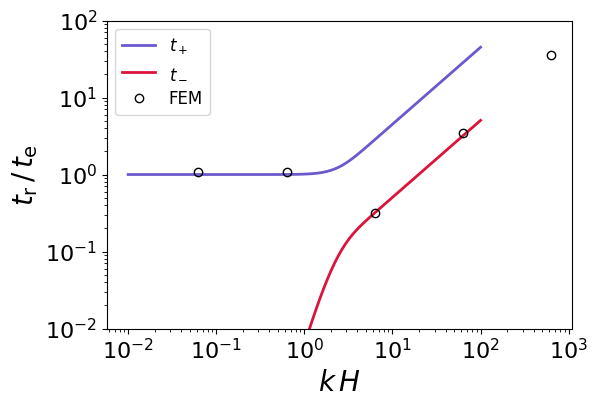

In [29]:
k = np.logspace(-2,2,100)
t_theory = t_p(k)
t_hydro = t_m(k)

k_ex = (2*np.pi/lamdas)

%matplotlib inline 
plt.figure(figsize=(6,4))
plt.plot(k,t_theory,color='slateblue',linewidth=2,label=r'$t_+$')
plt.plot(k,t_hydro,color='crimson',linewidth=2,label=r'$t_-$')
plt.plot(k_ex,t_decay,'ko',markersize=6,fillstyle='none',linewidth=2,label=r'FEM')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2,1e2)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r'$k\,H$',fontsize=20)
plt.ylabel(r'$t_\mathrm{r}\,/\,t_\mathrm{e}$',fontsize=20)
plt.legend(fontsize=12)
plt.show()